# Certaines langues sont-elles plus difficiles à analyser que d'autres ?

# Import des modules et paramétrage du notebook

In [0]:
IS_DRIVE = True
BASE_PATH = "drive/My Drive/univ/master-2/TAL/projet"

In [2]:
if IS_DRIVE:
    # install dependencies
    !pip install conllu ipython-autotime
    
    # mount drive
    from google.colab import drive
    drive.mount('drive')
    
    # change currrent directory path in order to import own modules
    import os
    os.chdir(BASE_PATH)

# Pour que les changements dans les modules importés soient pris en compte
%load_ext autoreload
%autoreload 2

# Pour afficher les figures dans le notebook
%matplotlib inline

# Pour afficher le temps d'exécution de chacune des cellules du notebook
%load_ext autotime

# extra modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# own modules
from corpus import parse_from_conllu
from features import FEATURE_NAMES

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [12]:
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

time: 21.8 ms


# Chargement des données

In [3]:
if IS_DRIVE:
    corpus_path = "data/corpus"
    scores_path = "data/scores.txt"
else:
    corpus_path = BASE_PATH + "/data/corpus"
    scores_path = BASE_PATH + "/data/scores.txt"

df = pd.read_csv(scores_path, sep=",", header=None)
df.columns = ['lang', 'las', 'uas']

lang_codes = df['lang']
scores = {'las': df['las'], 'uas': df['uas']}

corpus, features = parse_from_conllu(pathname_dir=corpus_path,
                                     lang_codes=lang_codes)

Parsing hi... done ! extracting features... done !
Parsing it... done ! extracting features... done !
Parsing ur... done ! extracting features... done !
Parsing pl... done ! extracting features... done !
Parsing ja... done ! extracting features... done !
Parsing no... done ! extracting features... done !
Parsing bg... done ! extracting features... done !
Parsing el... done ! extracting features... done !
Parsing ca... done ! extracting features... done !
Parsing sv... done ! extracting features... done !
Parsing fr... done ! extracting features... done !
Parsing pt... done ! extracting features... done !
Parsing ru... done ! extracting features... done !
Parsing da... done ! extracting features... done !
Parsing id... done ! extracting features... done !
Parsing en... done ! extracting features... done !
Parsing es... done ! extracting features... done !
Parsing uk... done ! extracting features... done !
Parsing ro... done ! extracting features... done !
Parsing ga... done ! extracting

## Comment utiliser les structures de données utilisées

In [4]:
# phrases = corpus[0]
# phrase = phrases[0]
# mot = phrase[0]

# print(f"lang_code\n\t{lang_codes[0]}\n")
# print(f"première phrase\n\t{phrase}\n")
# print(f"premier mot\n\t{mot}\n")
# print(f"nombre de clés disponibles par mot\n\t{len(mot)}\n")
# print(f"clés disponibles par mot\n\t{mot.keys()}\n")

time: 774 µs


# Régression multiple pour expliquer les performances de l'analyseur syntaxique

## Features utilisés

In [5]:
print(len(FEATURE_NAMES))
FEATURE_NAMES

28


['number_of_sentences',
 'mean_length_of_a_sentence',
 'variance_length_of_a_sentence',
 'vocab_size',
 'mean_distance_to_head',
 'max_nested_dependency',
 'var_distance_to_head',
 'var_max_nested_dependency',
 'root_std',
 'non_projective',
 'DET',
 'NOUN',
 'ADP',
 'VERB',
 'ADJ',
 'PUNCT',
 'SCONJ',
 'PRON',
 'AUX',
 'CCONJ',
 'PROPN',
 'ADV',
 'NUM',
 'PART',
 'INTJ',
 'SYM',
 'X',
 '_']

time: 4.76 ms


## Mettre les données dans un pandas DataFrame pour faciliter les graphiques

In [6]:
df = pd.DataFrame(features, columns=FEATURE_NAMES)

df["las"] = pd.Series(scores["las"])
df["uas"] = pd.Series(scores["uas"])
df["lang_code"] = pd.Series(lang_codes)

time: 6.57 ms


## Afficher les répartitions + la ligne de régression pour chacun des features

In [11]:
hover_data = "lang_code"

for feature_idx, feature_name in enumerate(FEATURE_NAMES):
    # create our subplots
    fig = make_subplots(
        rows=1,
        cols=2,
        shared_xaxes=True,
        subplot_titles=["las", "uas"]
    )

    # adding las points
    for score_idx, score_name in zip([1, 2], ["las", "uas"]):
        fig.add_trace(
            go.Scatter(
                x=df[feature_name],
                y=df[score_name],
                name=feature_name,
                text=df[hover_data],
                mode="markers+text",
                marker=dict(
                    size=20,
                    color="yellow"
                ),
                showlegend=False,
            ), row=1, col=score_idx
        )

        # fixme : less hacky
        tmp = px.scatter(df, x=feature_name, y=score_name, trendline="ols")
        trendline = tmp.data[1]
        fig.add_trace(trendline, row=1, col=score_idx)
    
    fig.update_layout(title=feature_name)

    fig.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



time: 22.6 s


## Afficher la matrice de corrélations croisées

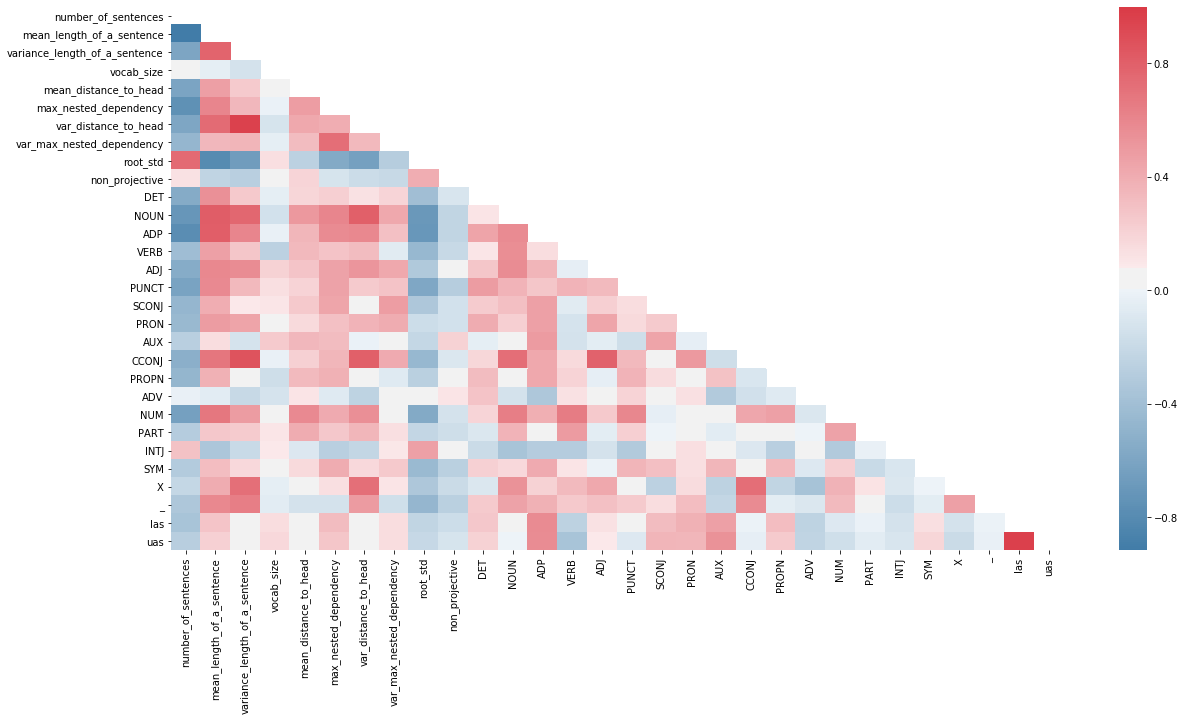

time: 705 ms


In [13]:
# get only the bottom part of the matrix
corrs = df.corr(method="pearson")
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot
fig, ax = f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
ax = sns.heatmap(corrs, mask=mask, cmap=cmap)
plt.show()

## En avant pour la régression !

* LinearRegression
* Ridge
* Lasso
* ElasticNet

In [ ]:
def train_classifiers(features, scores):
    classifiers = dict()

    for score_name in scores.keys():
        classifiers[score_name] = {
            "linear_reg": LinearRegression(),
            "ridge": Ridge(),
            "lasso": Lasso(),
            "elasticnet": ElasticNet()
        }

    for score_name, score in scores.items():
        for classifier_name, classifier in classifiers[score_name].items():
            classifier.fit(features, score)
    
    return classifiers

# train + print
classifiers = train_classifiers(features, scores)
for score_name, score in scores.items():
    print(score_name)
    for classifier_name, classifier in classifiers[score_name].items():
        print(classifier_name, classifier.score(features, score))
    print()

## Afficher les prédictions et les valeurs réelles

In [ ]:
x_range = np.arange(0, len(features))

for y_name, y in Y.items():
    print(y_name)
    for clf_name, clf in classifiers[y_name].items():
        y_pred = clf.predict(X)
        #def get_line(x):
        #    return clf.intercept_ + x @ clf.coef_
        #plt.plot(x_range, get_line(X), label="preds_line")

        # fig, ax = plt.subplots(nrows=1, ncols=len(classifiers))
        
        plt.scatter(x_range, y_pred, label="preds")
        plt.scatter(x_range, y, label="trues")
        plt.title(f"{clf_name}, score = {clf.score(X, y)}")
        
    plt.legend()
    plt.show()


##
classifiers = train_classifiers(features, scores)
for score_name, score in scores.items():
    print(score_name)
    for classifier_name, classifier in classifiers[score_name].items():
        print(classifier_name, classifier.score(features, score))
    print()

In [ ]:
x_range = np.arange(0, len(features))

# create our subplots
fig = make_subplots(
    rows=2,
    cols=len(classifiers["las"]),
    shared_xaxes=True,
    shared_yaxes=True,
    subplot_titles=["linear_reg", "ridge", "lasso", "elasticnet"],
    vertical_spacing=0.02
)


for score_idx, score_name in zip([1, 2], ["las", "uas"]):
    for classifier_idx, classifier in enumerate(classifiers[score_name].values()):
        classifier_idx += 1

        x = np.array(df[FEATURE_NAMES])
        y_pred = classifier.predict(x)

        # add true points
        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=df[score_name],
                text=df['lang_code'],
                mode="markers",
                marker=dict(
                    size=8,
                    color="yellow"
                ),
            ), row=score_idx, col=classifier_idx
        )

        # add prediction points
        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=list(y_pred),
                text=df['lang_code'],
                mode="markers",
                marker=dict(
                    size=8,
                    color="blue"
                ),
            ), row=score_idx, col=classifier_idx
        )

fig.update_layout(
    autosize=False,
    width=1300,
    height=800,
    showlegend=False
)
fig.show()

# Affichage des pays les plus éloignés des prédictions pour chaque feature (non terminé)

In [ ]:
"""
pour chaque feature
    worst = 5 langues les plus éloignés
    best  = 5 langues les plus proches
"""

"""
score_name = "las"

for feature_name in FEATURE_NAMES:
    x = np.array(df[feature_name]).reshape(-1, 1)
    y_true = np.array(df[score_name]).reshape(-1, 1)

    clf = LinearRegression()
    clf.fit(x, y_true)

    y_pred = clf.predict(x)

    differences = abs(y_true - y_pred)
    worst = np.argmin(differences)
    best = np.argmax(differences)
"""
print()

In [16]:
"""
pour chaque feature
    worst = 5 langues les plus éloignés
    best  = 5 langues les plus proches
"""

"""
score_name = "las"

for feature_name in FEATURE_NAMES:
    x = np.array(df[feature_name]).reshape(-1, 1)
    y_true = np.array(df[score_name]).reshape(-1, 1)

    clf = LinearRegression()
    clf.fit(x, y_true)

    y_pred = clf.predict(x)

    differences = abs(y_true - y_pred)
    worst = np.argmin(differences)
    best = np.argmax(differences)
"""
print()

las
linear_reg 0.8594753848005701
ridge 0.7610168453488123
lasso 0.5147367060203407
elasticnet 0.49221389776994073

uas
linear_reg 0.8372904161184409
ridge 0.7438166484677904
lasso 0.5201900091669915
elasticnet 0.5018738574004158

time: 21.5 ms


## Afficher les prédictions et les valeurs réelles

In [0]:
x_range = np.arange(0, len(features))

for y_name, y in Y.items():
    print(y_name)
    for clf_name, clf in classifiers[y_name].items():
        y_pred = clf.predict(X)
        #def get_line(x):
        #    return clf.intercept_ + x @ clf.coef_
        #plt.plot(x_range, get_line(X), label="preds_line")

        # fig, ax = plt.subplots(nrows=1, ncols=len(classifiers))
        
        plt.scatter(x_range, y_pred, label="preds")
        plt.scatter(x_range, y, label="trues")
        plt.title(f"{clf_name}, score = {clf.score(X, y)}")
        
    plt.legend()
    plt.show()


##
classifiers = train_classifiers(features, scores)
for score_name, score in scores.items():
    print(score_name)
    for classifier_name, classifier in classifiers[score_name].items():
        print(classifier_name, classifier.score(features, score))
    print()

In [48]:
x_range = np.arange(0, len(features))

# create our subplots
fig = make_subplots(
    rows=2,
    cols=len(classifiers["las"]),
    shared_xaxes=True,
    shared_yaxes=True,
    subplot_titles=["linear_reg", "ridge", "lasso", "elasticnet"],
    vertical_spacing=0.02
)


for score_idx, score_name in zip([1, 2], ["las", "uas"]):
    for classifier_idx, classifier in enumerate(classifiers[score_name].values()):
        classifier_idx += 1

        x = np.array(df[FEATURE_NAMES])
        y_pred = classifier.predict(x)

        # add true points
        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=df[score_name],
                text=df['lang_code'],
                mode="markers",
                marker=dict(
                    size=8,
                    color="yellow"
                ),
            ), row=score_idx, col=classifier_idx
        )

        # add prediction points
        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=list(y_pred),
                text=df['lang_code'],
                mode="markers",
                marker=dict(
                    size=8,
                    color="blue"
                ),
            ), row=score_idx, col=classifier_idx
        )

fig.update_layout(
    autosize=False,
    width=1300,
    height=800,
    showlegend=False
)
fig.show()

time: 284 ms


# Affichage des pays les plus éloignés des prédictions pour chaque feature (non terminé)

In [17]:
"""
pour chaque feature
    worst = 5 langues les plus éloignés
    best  = 5 langues les plus proches
"""

"""
score_name = "las"

for feature_name in FEATURE_NAMES:
    x = np.array(df[feature_name]).reshape(-1, 1)
    y_true = np.array(df[score_name]).reshape(-1, 1)

    clf = LinearRegression()
    clf.fit(x, y_true)

    y_pred = clf.predict(x)

    differences = abs(y_true - y_pred)
    worst = np.argmin(differences)
    best = np.argmax(differences)
"""
print()


time: 2.13 ms
